<a href="https://colab.research.google.com/github/AntonioBorz/CourseWork_ClassicML/blob/main/7_%D0%9A%D0%BB%D0%B0%D1%81%D1%81%D0%B8%D1%84%D0%B8%D0%BA%D0%B0%D1%86%D0%B8%D1%8F_%D0%BF%D1%80%D0%B5%D0%B2%D1%8B%D1%88%D0%B0%D0%B5%D1%82_%D0%BB%D0%B8_%D0%B7%D0%BD%D0%B0%D1%87%D0%B5%D0%BD%D0%B8%D0%B5_SI_%D0%BC%D0%B5%D0%B4%D0%B8%D0%B0%D0%BD%D0%BD%D0%BE%D0%B5_%D0%B7%D0%BD%D0%B0%D1%87%D0%B5%D0%BD%D0%B8%D0%B5_%D0%B2%D1%8B%D0%B1%D0%BE%D1%80%D0%BA%D0%B8_Borzunov_A_A_CML_%D0%9A%D1%83%D1%80%D1%81%D0%BE%D0%B2%D0%B0%D1%8F_%D1%80%D0%B0%D0%B1%D0%BE%D1%82%D0%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **7. Классификация - превышает ли значение SI медианное значение выборки**

In [1]:
# Импортируем необходимые библиотеки
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                            f1_score, roc_auc_score, confusion_matrix,
                            classification_report, roc_curve, auc)
import xgboost as xgb
!pip install catboost
from catboost import CatBoostClassifier
import joblib
from scipy import stats

import warnings
warnings.filterwarnings('ignore')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 5.8 MB/s eta 0:00:00


1. Загрузка данных после EDA

In [2]:
# Загружаем данные
drive.mount('/content/drive')
df = pd.read_excel('/content/drive/MyDrive/EDAprocessed_data.xlsx')

Mounted at /content/drive


In [3]:
# Проверим датасет
print(f"Количество строк: {len(df)}")
print(f"Количество столбцов: {len(df.columns)}")

# Посмотрим первые строчки
df.head()

Количество строк: 969
Количество столбцов: 178


,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,NumRadicalElectrons,MaxPartialCharge,MinPartialCharge,FpDensityMorgan3,BCUT2D_MWHI,...,log_SI,"IC50, mM","CC50, mM",SI,Charge_Difference,Charge_Stability,EState_Range,Total_Functional_Groups,Functional_Diversity,Complexity_Score
0,5.094096,0.387225,0.387225,0.417362,42.928571,0,0.038844,-0.293526,1.321429,14.822266,...,3.371597,6.239374,175.482382,28.125000,0.332369,0.717222,4.706871,11,4,4.998389
1,3.961417,0.533868,0.533868,0.462473,45.214286,0,0.012887,-0.313407,1.285714,14.975110,...,2.079442,0.771831,5.402819,7.000000,0.326294,0.721593,3.427548,9,3,4.928514
2,2.627117,0.543231,0.543231,0.260923,42.187500,0,0.094802,-0.325573,1.156250,15.353938,...,0.542324,223.808778,161.142320,0.720000,0.420375,0.656801,2.083887,11,4,4.353918
3,5.097360,0.390603,0.390603,0.377846,41.862069,0,0.038844,-0.293526,1.310345,14.821216,...,4.162553,1.705624,107.855654,63.235294,0.332369,0.717223,4.706757,12,4,4.924259
4,5.150510,0.270476,0.270476,0.429038,36.514286,0,0.062897,-0.257239,1.257143,14.831112,...,0.832909,107.131532,139.270991,1.300000,0.320137,0.726050,4.880034,8,3,4.556793


2. Подготовка данных

In [4]:
# Вычисляем медианное значение SI
median_si = df['SI'].median()
df['SI_above_median'] = (df['SI'] > median_si).astype(int)
target_class_si = 'SI_above_median'

print(f"Медианное значение SI: {median_si:.4f}")
print(f"Распределение классов:\n{df[target_class_si].value_counts(normalize=True)}")

Медианное значение SI: 3.9000
Распределение классов:
SI_above_median
0    0.500516
1    0.499484
Name: proportion, dtype: float64


In [5]:
# Используем те же признаки (исключаем целевые переменные)
exclude_cols = ['IC50, mM', 'log_IC50, mM', 'CC50, mM', 'log_CC50, mM', 'SI', 'log_SI']
X_class = df.drop(exclude_cols + [target_class_si], axis=1)
y_class = df[target_class_si]

In [6]:
# Разделяем данные стратифицированно
X_train_si, X_test_si, y_train_si, y_test_si = train_test_split(
    X_class, y_class, test_size=0.2, random_state=42, stratify=y_class
)
print(f"Обучающая выборка: {X_train_si.shape}, Тестовая: {X_test_si.shape}.")

Обучающая выборка: (775, 172), Тестовая: (194, 172).


In [7]:
# Масштабируем данные
scaler_class_si = RobustScaler()
X_train_si_scaled = scaler_class_si.fit_transform(X_train_si)
X_test_si_scaled = scaler_class_si.transform(X_test_si)

3. Определение и подготовка набора моделей

In [10]:
# Рассчитываем веса классов
positive_count = sum(y_train_si == 1)
negative_count = sum(y_train_si == 0)
scale_pos_weight = negative_count / positive_count if positive_count > 0 else 1

# Определяем набор классификаторов для SI с балансировкой
models_si = {
    'RandomForest': RandomForestClassifier(
        n_estimators=300, random_state=42, n_jobs=-1,
        class_weight='balanced'
    ),
    'GradientBoosting': GradientBoostingClassifier(n_estimators=200, random_state=42),
    'XGBoost': xgb.XGBClassifier(
        eval_metric='logloss', random_state=42,
        scale_pos_weight=scale_pos_weight
    ),
    'CatBoost': CatBoostClassifier(
        iterations=300, verbose=False, random_state=42,
        auto_class_weights='Balanced'
    ),
    'LogisticRegression': LogisticRegression(
        max_iter=5000, random_state=42, class_weight='balanced', n_jobs=-1
    ),
    'KNN': KNeighborsClassifier(n_jobs=-1)
}

4. Оценка моделей и выбор лучшей модели

In [11]:
# Создаем функцию для оценки классификаторов
def evaluate_classifiers(models, X_train, X_test, y_train, y_test, cv_folds=5):
    """Оцениваем модели классификации с помощью кросс-валидации и тестовой выборки"""
    results = {}

    for name, model in models.items():
        print(f"\nОцениваем модель: {name}")

        try:
            # Кросс-валидация (ROC-AUC)
            cv_scores = cross_val_score(model, X_train, y_train, cv=cv_folds,
                                       scoring='roc_auc', n_jobs=-1)

            # Обучение модели
            model.fit(X_train, y_train)

            # Предсказания
            y_pred_test = model.predict(X_test)
            y_proba_test = model.predict_proba(X_test)[:, 1]

            # Вычисление метрик
            results[name] = {
                'CV_AUC_mean': cv_scores.mean(),
                'CV_AUC_std': cv_scores.std(),
                'Accuracy': accuracy_score(y_test, y_pred_test),
                'Precision': precision_score(y_test, y_pred_test),
                'Recall': recall_score(y_test, y_pred_test),
                'F1': f1_score(y_test, y_pred_test),
                'ROC_AUC': roc_auc_score(y_test, y_proba_test),
                'Model': model
            }

            print(f"Test ROC-AUC: {results[name]['ROC_AUC']:.4f}")
            print(f"Test F1: {results[name]['F1']:.4f}")

        except Exception as e:
            print(f"Ошибка при оценке модели: {str(e)}")

    return results

In [12]:
# Для моделей, не требующих масштабирования (деревья и проч.)
tree_models_si = {k: v for k, v in models_si.items() if k not in ['LogisticRegression', 'KNN']}
results_original_si = evaluate_classifiers(tree_models_si, X_train_si, X_test_si, y_train_si, y_test_si)

# Для моделей, требующих масштабирования
scaled_models_si = {k: v for k, v in models_si.items() if k in ['LogisticRegression', 'KNN']}
results_scaled_si = evaluate_classifiers(scaled_models_si, X_train_si_scaled, X_test_si_scaled,
                                         y_train_si, y_test_si)

# Объединяем результаты
all_results_si = {**results_original_si, **{f"{k}_scaled": v for k, v in results_scaled_si.items()}}
results_df_si = pd.DataFrame(all_results_si).T
results_df_si = results_df_si.sort_values('ROC_AUC', ascending=False)


Оцениваем модель: RandomForest
Test ROC-AUC: 0.6778
Test F1: 0.6077

Оцениваем модель: GradientBoosting
Test ROC-AUC: 0.6476
Test F1: 0.5789

Оцениваем модель: XGBoost
Test ROC-AUC: 0.6850
Test F1: 0.6196

Оцениваем модель: CatBoost
Test ROC-AUC: 0.6806
Test F1: 0.6188

Оцениваем модель: LogisticRegression
Test ROC-AUC: 0.6618
Test F1: 0.6054

Оцениваем модель: KNN
Test ROC-AUC: 0.6620
Test F1: 0.5851


In [13]:
# Выбираем лучшую модель
best_model_name_si = results_df_si.index[0]
best_model_si = results_df_si.loc[best_model_name_si, 'Model']
best_model_type = type(best_model_si).__name__

print(f"Лучшая модель: {best_model_name_si} ({best_model_type})")
print(f"Test ROC-AUC: {results_df_si.loc[best_model_name_si, 'ROC_AUC']:.4f}")
print(f"Test F1: {results_df_si.loc[best_model_name_si, 'F1']:.4f}")

Лучшая модель: XGBoost (XGBClassifier)
Test ROC-AUC: 0.6850
Test F1: 0.6196


In [14]:
# Донастраиваем модель
if 'CatBoost' in best_model_name_si:
    param_grid = {
        'iterations': [500, 700],
        'depth': [6, 8],
        'learning_rate': [0.05, 0.1],
        'l2_leaf_reg': [3, 5]
    }
elif 'XGBoost' in best_model_name_si:
    param_grid = {
        'n_estimators': [300, 400],
        'max_depth': [5, 7],
        'learning_rate': [0.05, 0.1],
        'subsample': [0.8, 0.9]
    }
elif 'RandomForest' in best_model_name_si:
    param_grid = {
        'n_estimators': [300, 400],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2],
        'max_features': ['sqrt', 'log2']
    }
elif 'GradientBoosting' in best_model_name_si:
    param_grid = {
        'n_estimators': [200, 300],
        'learning_rate': [0.1, 0.2],
        'max_depth': [3, 5],
        'subsample': [0.8, 0.9]
    }
else:
    param_grid = {}

if param_grid:
    random_search = RandomizedSearchCV(
        estimator=best_model_si,
        param_distributions=param_grid,
        n_iter=15,  # Оптимальный баланс скорости и качества
        cv=3,
        scoring='roc_auc',
        n_jobs=-1,
        random_state=42,
        verbose=1
    )

    # Выбираем правильные данные
    if 'scaled' in best_model_name_si:
        X_train_final, X_test_final = X_train_si_scaled, X_test_si_scaled
    else:
        X_train_final, X_test_final = X_train_si, X_test_si

    random_search.fit(X_train_final, y_train_si)
    tuned_model = random_search.best_estimator_

    # Оцениваем настроенную модель
    y_proba_tuned = tuned_model.predict_proba(X_test_final)[:, 1]
    tuned_auc = roc_auc_score(y_test_si, y_proba_tuned)
    y_pred_tuned = tuned_model.predict(X_test_final)
    tuned_f1 = f1_score(y_test_si, y_pred_tuned)

    original_auc = results_df_si.loc[best_model_name_si, 'ROC_AUC']
    original_f1 = results_df_si.loc[best_model_name_si, 'F1']

    print(f"Лучшие параметры: {random_search.best_params_}")
    print(f"Test ROC-AUC после настройки: {tuned_auc:.4f} (было {original_auc:.4f})")
    print(f"Test F1 после настройки: {tuned_f1:.4f} (было {original_f1:.4f})")

    # Выбираем лучшую модель на основе ROC-AUC
    if tuned_auc > original_auc:
        final_model = tuned_model
        print("Настроенная модель лучше исходной по ROC-AUC.")
    else:
        final_model = best_model_si
        print("Исходная модель лучше или равна настроенной по ROC-AUC.")
else:
    final_model = best_model_si

y_pred_final = final_model.predict(X_test_final)
y_proba_final = final_model.predict_proba(X_test_final)[:, 1]

Fitting 3 folds for each of 15 candidates, totalling 45 fits
Лучшие параметры: {'subsample': 0.9, 'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.05}
Test ROC-AUC после настройки: 0.6791 (было 0.6850)
Test F1 после настройки: 0.6243 (было 0.6196)
Исходная модель лучше или равна настроенной по ROC-AUC.


5. Анализ результатов и оценка важности признаков

In [15]:
# Важность признаков
if hasattr(final_model, 'feature_importances_'):
    importances = final_model.feature_importances_
elif hasattr(final_model, 'coef_'):
    importances = np.abs(final_model.coef_[0])
else:
    # Для моделей без атрибута важности
    from sklearn.inspection import permutation_importance
    result = permutation_importance(final_model, X_test_final, y_test_si, n_repeats=10, random_state=42)
    importances = result.importances_mean

# Нормализация важности
importances = 100.0 * (importances / importances.max())
feature_importance_si = pd.DataFrame({
    'Feature': X_class.columns,
    'Importance': importances
}).sort_values('Importance', ascending=False)

print("Топ-10 важных признаков для классификации:")
print(feature_importance_si.head(10))

Топ-10 важных признаков для классификации:
                     Feature  Importance
105        fr_Ndealkylation2  100.000000
79   NumAliphaticCarbocycles   78.477325
77              FractionCSP3   28.448395
26                PEOE_VSA13   22.151808
16              BCUT2D_MRLOW   16.179995
85            NumHeteroatoms   14.646101
78                 NHOHCount   13.447496
100                   fr_NH0   11.415600
161              fr_thiazole   10.962328
22                 PEOE_VSA1   10.005999


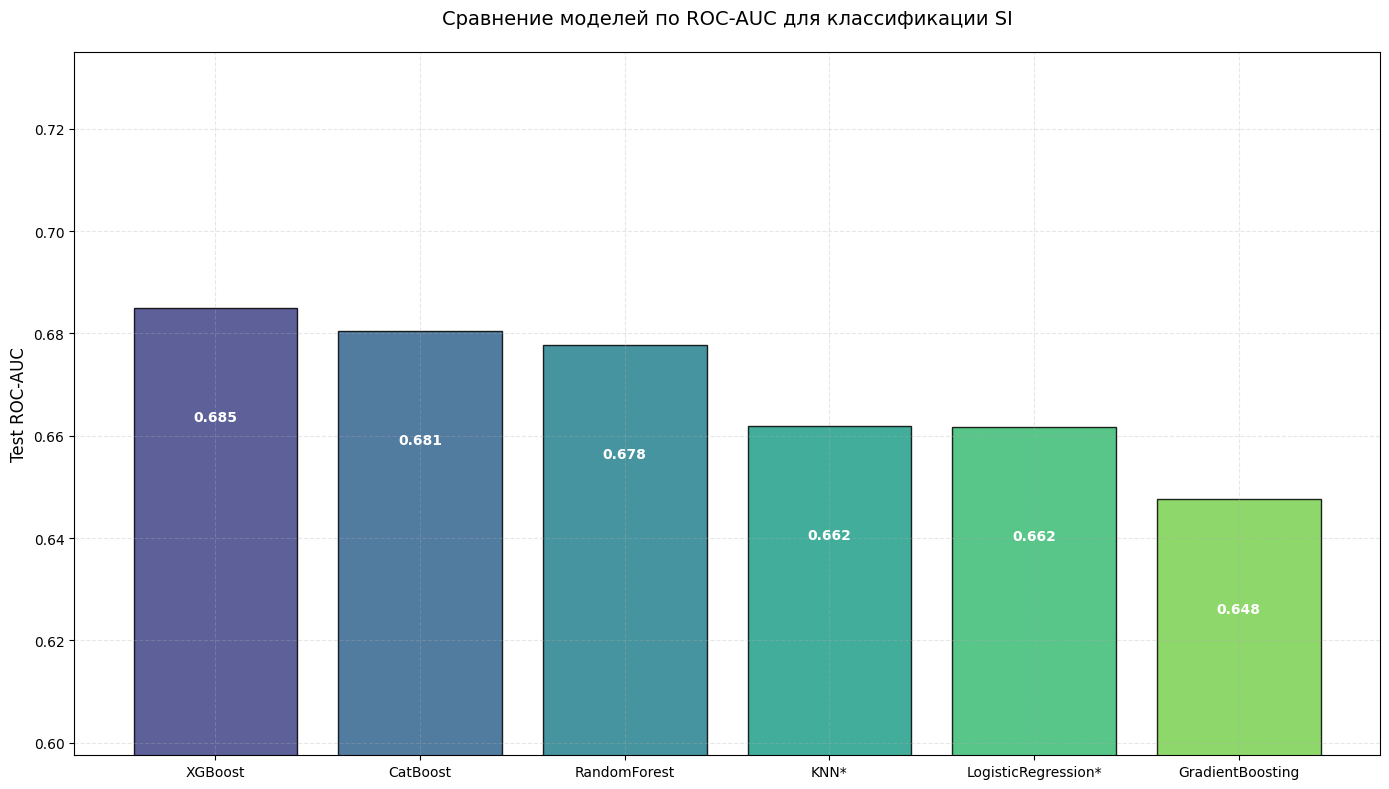

In [16]:
# Сравнение моделей по ROC-AUC
plt.figure(figsize=(14, 8))
top_models = results_df_si.head(8)
model_names = [name.replace('_scaled', '*') for name in top_models.index]
roc_auc_scores = top_models['ROC_AUC'].values
colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(model_names)))
bars = plt.bar(model_names, roc_auc_scores, color=colors, edgecolor='black', alpha=0.85)
plt.xticks(fontsize=10)
plt.ylabel('Test ROC-AUC', fontsize=12)
plt.title('Сравнение моделей по ROC-AUC для классификации SI', fontsize=14, pad=20)
plt.grid(True, alpha=0.3, linestyle='--')
plt.ylim(min(roc_auc_scores) - 0.05, max(roc_auc_scores) + 0.05)

# Добавляем значения на столбцы
for bar, score in zip(bars, roc_auc_scores):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height-0.02, f'{score:.3f}',
             ha='center', va='top', color='white', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

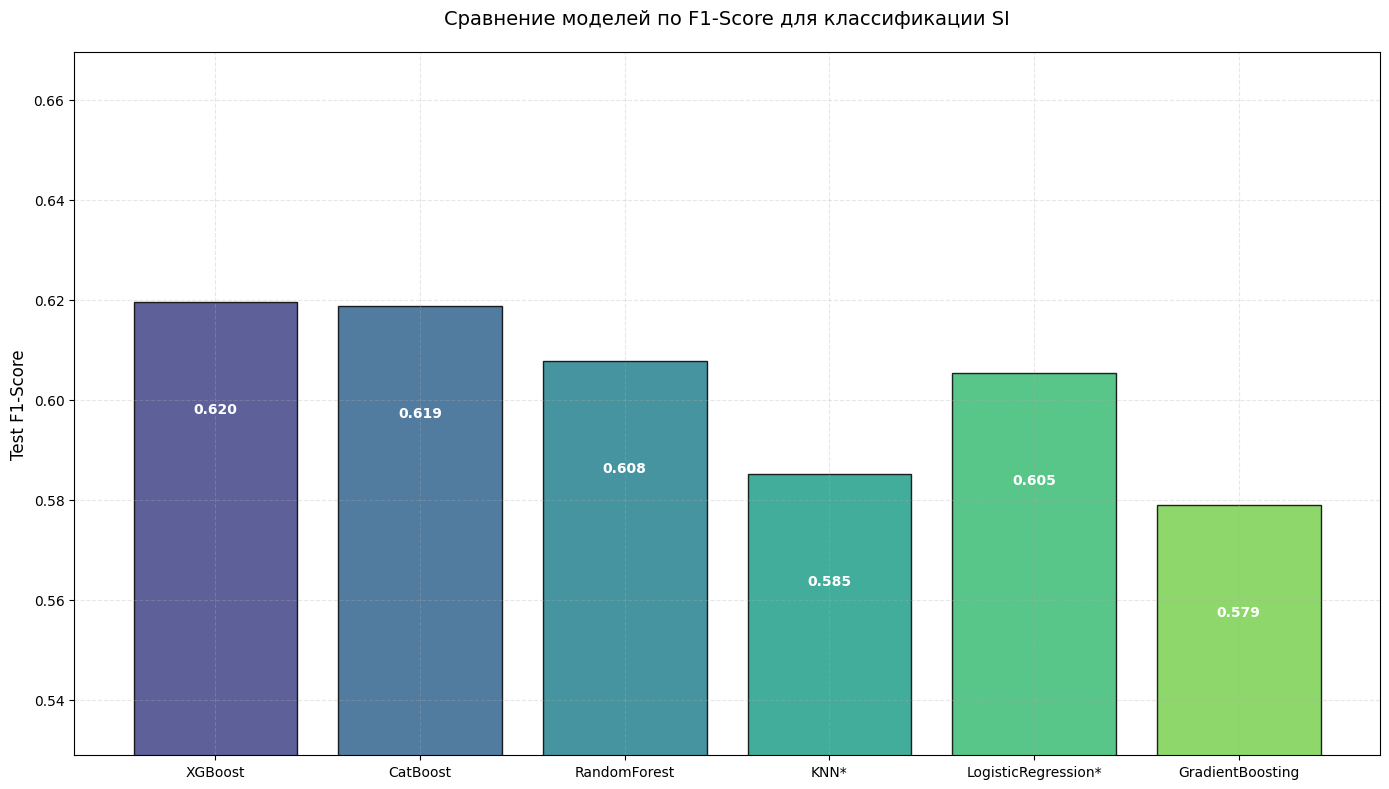

In [17]:
# Сравнение моделей по F1-Score
plt.figure(figsize=(14, 8))
f1_scores = top_models['F1'].values
bars = plt.bar(model_names, f1_scores, color=colors, edgecolor='black', alpha=0.85)
plt.xticks(fontsize=10)
plt.ylabel('Test F1-Score', fontsize=12)
plt.title('Сравнение моделей по F1-Score для классификации SI', fontsize=14, pad=20)
plt.grid(True, alpha=0.3, linestyle='--')
plt.ylim(min(f1_scores) - 0.05, max(f1_scores) + 0.05)

# Добавляем значения на столбцы
for bar, score in zip(bars, f1_scores):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height-0.02, f'{score:.3f}',
             ha='center', va='top', color='white', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

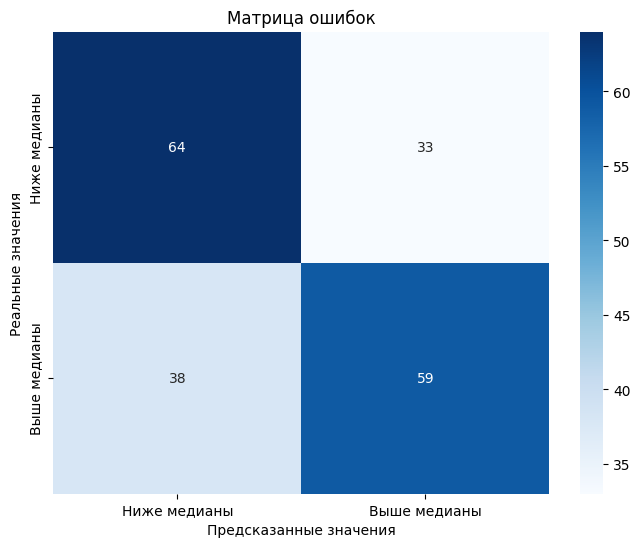

In [18]:
# Матрица ошибок
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test_si, y_pred_tuned)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Ниже медианы', 'Выше медианы'],
            yticklabels=['Ниже медианы', 'Выше медианы'])
plt.xlabel('Предсказанные значения')
plt.ylabel('Реальные значения')
plt.title('Матрица ошибок')
plt.show()

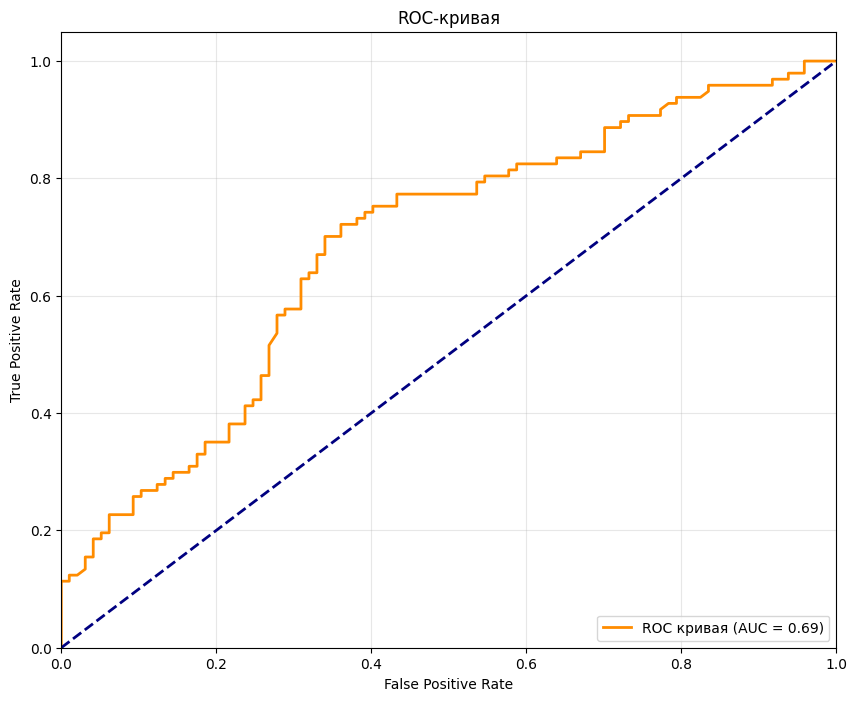

In [19]:
# ROC-кривая
plt.figure(figsize=(10, 8))
y_proba_final = final_model.predict_proba(X_test_final)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test_si, y_proba_final)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC кривая (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

In [20]:
# Выводы
print(f"Медианное значение SI: {median_si:.4f}")
print(f"Доля объектов > медианы: {df[target_class_si].mean():.2%}")
print(f"Всего объектов: {len(y_pred_final)}")
print(f"Превышают медиану: {sum(y_pred_final)} ({sum(y_pred_final)/len(y_pred_final):.1%})")

Медианное значение SI: 3.9000
Доля объектов > медианы: 49.95%
Всего объектов: 194
Превышают медиану: 87 (44.8%)


In [21]:
# Сохраняем модель
joblib.dump(final_model, 'si_best_classifier.pkl')

# Сохраняем результаты
results_df_si.to_csv('si_classification_results.csv')
feature_importance_si.to_csv('si_feature_importance.csv')
print("Результаты сохранены!")

Результаты сохранены!
